In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt

from IPython.core.pylabtools import figsize
figsize(11, 9)

import collections

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/aapopovkin/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Handy snippet to reset the global graph and global session.
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  tf.reset_default_graph()
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

This is model, where we should do binary classification - predict probability of A

   1) num_classes - number of classes
   
   2) each class has its popability of A
   
   3) prob - array of these probabilities; they are Q - coordinates for Hamiltonian MCMC
   
   4) prior (alpha, beta) are two float variables describing beta-distribution classes' popabilities.

In [3]:
def get_sample_data():
    ps_data_arr = np.array([
        [20, 2, 1, 0.1],
        [20, 2, 2, 0.1],
        [20, 2, 3, 0.1],
        [20, 2, 4, 0.1],
        [20, 2, 5, 0.1],
        [20, 2, 6, 0.1],
        [20, 2, 7, 0.1],
        [20, 2, 8, 0.1],
        [20, 2, 9, 0.1],
        [20, 2, 10, 0.1],
        [20, 2, 11, 0.1],
        [20, 2, 12, 0.1],
        [20, 2, 13, 0.1],
        [20, 2, 14, 0.1],
        [20, 2, 15, 0.1],
        
        #[20, 10, 1, 0.499993], [20, 3, 2, 0.230211], [20, 8, 3, 0.236831], 
        #[20, 7, 4, 0.246463], [20, 6, 5, 0.370862], [20, 5, 6, 0.320656], 
        #[20, 10, 7, 0.519887], [20, 12, 8, 0.52845], [20, 8, 9, 0.453077], 
        #[20, 8, 10, 0.431245], [20, 10, 11, 0.499243], [20, 9, 12, 0.471968], 
        #[20, 2, 13, 0.152176], [20, 14, 14, 0.48496], [20, 6, 15, 0.246193]
    ])
    ps_data_pd=pd.DataFrame(data=ps_data_arr[0:, 0:],
             index=ps_data_arr[0:, 2],
             columns=["total_count", "clicks", "class_id", "true_p"],
             dtype=np.float32)
    ps_data_pd['class_id'] = ps_data_pd.class_id.astype('int32')
    
    return ps_data_pd

In [4]:
inv_alpha_transform = lambda y: np.log(y)  # Not using TF here.
fwd_alpha_transform = tf.exp

def _make_ps_prior(num_classes, dtype):
    raw_prior_alpha = tf.get_variable(
      name='raw_prior_alpha',
      initializer=np.array(inv_alpha_transform(5.), dtype=dtype))
    raw_prior_beta = tf.get_variable(
      name='raw_prior_beta',
      initializer=np.array(inv_alpha_transform(5.), dtype=dtype))   
    return tfd.Independent(
      tfd.Beta(
          fwd_alpha_transform(raw_prior_alpha) * tf.ones(num_classes),
          fwd_alpha_transform(raw_prior_beta) * tf.ones(num_classes) * 10),
      reinterpreted_batch_ndims=-1)#1)

make_ps_prior = tf.make_template(name_='make_ps_prior', func_=_make_ps_prior)

def _make_ps_log_likelihood(prob, class_id, total_count):
    prob_c = tf.gather(prob, indices=tf.to_int32(class_id - 1), axis=-1)
    total_count_c = tf.gather(total_count, indices=tf.to_int32(class_id - 1), axis=-1)
    return tfp.distributions.Binomial(total_count=tf.to_float(total_count_c), probs=prob_c)

make_ps_log_likelihood = tf.make_template(name_='make_ps_log_likelihood', func_=_make_ps_log_likelihood)

def joint_log_prob(prob, total_count, clicks, class_id, dtype):
    num_classes = len(total_count)
    rv_prob = make_ps_prior(num_classes, dtype)
    rv_clicks = make_ps_log_likelihood(prob, class_id, total_count)
    return (rv_prob.log_prob(prob) + 
         tf.reduce_sum(rv_clicks.log_prob(clicks), axis=-1))


def approximate_alpha_and_beta(ps_data_pd):
    
    dtype = np.float32
    def unnormalized_posterior_log_prob(prob):
        return joint_log_prob(
            prob=tf.sigmoid(prob),
            total_count=dtype(ps_data_pd.total_count.values),
            clicks=dtype(ps_data_pd.clicks.values),
            class_id=np.int32(ps_data_pd.class_id.values),
            dtype=dtype)

    step_size = tf.get_variable(
        'step_size',
        initializer=0.001,
        trainable=False)

    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=15,
        step_size=step_size,#0.01,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(target_rate=0.75),
        state_gradients_are_stopped=True)

    init_random_weights = tf.placeholder(dtype, shape=[len(ps_data_pd)])

    posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
        num_results=3,
        num_burnin_steps=0,
        num_steps_between_results=0,
        current_state=init_random_weights,
        kernel=hmc)

    loss = -tf.reduce_mean(kernel_results.accepted_results.target_log_prob)

    global_step = tf.train.get_or_create_global_step()

    learning_rate = tf.train.exponential_decay(
        learning_rate=0.1,
        global_step=global_step,
        decay_steps=2,
        decay_rate=0.995)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=global_step)

    init_op = tf.initialize_all_variables()
    with tf.variable_scope('make_ps_prior', reuse=True):
        prior_alpha = fwd_alpha_transform(tf.get_variable(
            name='raw_prior_alpha', dtype=dtype))
        prior_beta = fwd_alpha_transform(tf.get_variable(
            name='raw_prior_beta', dtype=dtype))

    init_op.run()
    w_ = 0.5 * np.ones([len(ps_data_pd)], dtype=dtype)
    
    #print(sess.run(kernel_results, feed_dict={init_random_weights: w_}))
    #return
    maxiter = int(3000)
    num_accepted = 0
    num_drawn = 0
    for i in range(maxiter):
        [
          _,
          global_step_,
          loss_,
          posterior_random_weights_,
          kernel_results_,
          step_size_,
          prior_alpha_,
          prior_beta_
        ] = sess.run([
          train_op,
          global_step,
          loss,
          posterior_random_weights,
          kernel_results,
          step_size,
          prior_alpha,
          prior_beta
        ], feed_dict={init_random_weights: w_})
        
        w_ = posterior_random_weights_[-1, :]
        num_accepted += kernel_results_.is_accepted.sum()
        num_drawn += kernel_results_.is_accepted.size
        acceptance_rate = num_accepted / num_drawn
        if i % 100 == 0 or i == maxiter - 1:
            print('global_step:{:>4}  loss:{: 7.1f}  acceptance:{:.3f}  '
                  'step_size:{:.3f}  prior_alpha:{:.4f}  prior_beta:{:.4f}'.format(
                      global_step_, loss_.mean(),
                      acceptance_rate, step_size_,
                      prior_alpha_, prior_beta_)
            )
            print (kernel_results_.proposed_state)

In [5]:
approximate_alpha_and_beta(get_sample_data())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
global_step:   1  loss:  227.0  acceptance:0.511  step_size:0.001  prior_alpha:5.0000  prior_beta:5.0000
[[0.4602567  0.4866573  0.49681962 0.4723181  0.47856086 0.4798139
  0.47910583 0.47254226 0.4808928  0.49378708 0.47938153 0.49030662
  0.47311938 0.4813422  0.46603793]
 [0.47503036 0.49244738 0.47043794 0.5189902  0.45163402 0.4410736
  0.43496537 0.46921536 0.43258336 0.4579056  0.4872854  0.46149376
  0.43039894 0.45715684 0.46838525]
 [0.43313983 0.45830327 0.47396332 0.472029   0.46035695 0.49499804
  0.45477408 0.44966516 0.454598   0.46678585 0.4449395  0.44348764
  0.45226088 0.44281474 0.448259  ]]
global_step: 101  loss:  155.8  acceptance:0.699  step_size:0.000  prior_alpha:17.4996  prior_beta:1.4245
[[0.2712634  0.33424997 0.283961

global_step:1101  loss:   17.8  acceptance:0.748  step_size:0.008  prior_alpha:10.2021  prior_beta:8.0379
[[-1.9212663 -2.5820298 -2.1268666 -1.6866078 -1.8946962 -1.9799445
  -2.535628  -2.2370374 -1.9240291 -2.0540807 -1.9493351 -2.126654
  -1.9541082 -1.7713524 -2.272952 ]
 [-2.00784   -2.6019597 -2.0439694 -1.699319  -2.0777752 -2.083114
  -2.629895  -2.1837957 -1.9563373 -2.1448853 -2.0116343 -2.0951068
  -1.927352  -1.6900679 -2.3292096]
 [-2.0724103 -2.6091537 -1.8955513 -1.8698119 -1.9681329 -2.0485861
  -2.7482371 -2.2117977 -1.9180654 -2.290329  -1.8367789 -2.1072497
  -1.9878508 -1.7890487 -2.3435483]]
global_step:1201  loss:   17.4  acceptance:0.748  step_size:0.009  prior_alpha:8.4152  prior_beta:9.1689
[[-2.3935905 -2.188885  -2.0824554 -2.3004515 -2.6881206 -2.5764976
  -2.3615422 -2.8537445 -2.5504837 -2.1940434 -2.3909943 -2.2442317
  -2.2935336 -2.592797  -2.026216 ]
 [-2.2498198 -2.1157944 -2.0810952 -2.5058005 -2.4455187 -2.472274
  -2.4755247 -2.7310772 -2.353504  

global_step:2501  loss:   17.5  acceptance:0.746  step_size:0.011  prior_alpha:10.6663  prior_beta:10.7579
[[-2.4430764 -2.542497  -1.9908836 -1.8234097 -2.4628506 -2.5672333
  -2.3941457 -2.417213  -2.4356081 -2.5502372 -2.3413355 -1.9157021
  -2.0698915 -2.3217828 -2.2510753]
 [-2.1918046 -2.441245  -2.325936  -2.1709661 -2.7705944 -2.3136363
  -2.4589279 -2.5521047 -2.3218353 -2.5850573 -2.6986096 -1.791299
  -2.0719476 -2.2847111 -2.1744146]
 [-2.0818996 -2.3927376 -2.044909  -1.8736668 -2.715059  -2.3472776
  -2.4158726 -2.426839  -2.492556  -2.6324232 -2.5946233 -2.0565803
  -2.4628077 -2.3955355 -2.1536632]]
global_step:2601  loss:   17.0  acceptance:0.746  step_size:0.014  prior_alpha:10.7857  prior_beta:10.7031
[[-2.454644  -2.1364815 -2.4381874 -2.2112708 -2.3550994 -2.0567217
  -2.2773485 -2.0890896 -2.7903774 -2.2667525 -2.2446551 -2.3841987
  -2.5209801 -2.3269002 -2.476519 ]
 [-2.2896423 -1.9556082 -2.6398263 -2.1948497 -2.359697  -2.1122885
  -2.2101285 -1.9556041 -2.764

In [6]:
import numpy as np

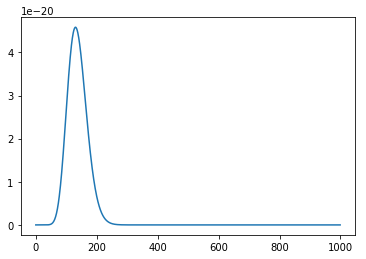

In [7]:
x = np.linspace(0, 1, 1000)
y = (x ** 15) * (1 - x) ** 100
plt.plot(y)
plt.show()